In [1]:
from typing import Dict,List
from string import ascii_lowercase
from random import choice
from collections import defaultdict
import json
import json
import pandas as pd
import os
import numpy as np
from os.path import join
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.stats import ks_2samp, norm
from statsmodels.stats.weightstats import ttest_ind
import re
from os.path import isdir, isfile
from tqdm.notebook import tqdm
import warnings
from time import sleep
import tendims as tendims

[nltk_data] Downloading package punkt to /home/danie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Download the embeddings from https://github.com/lajello/tendimensions
if not isdir("embeddings"):
    if not isfile("tendimensions_embeddings.zip"):
        print("Fetching embeddings...")
        !wget http://www.lajello.com/files/tendimensions_embeddings.zip
    print("Unpacking embeddings...")
    !unzip tendimensions_embeddings.zip
    print("Done!")
else:
    print("Using previously fetched embeddings.")

Using previously fetched embeddings.


In [3]:
model = tendims.TenDimensionsClassifier(is_cuda=False, embeddings_dir = './embeddings') #set is_cuda to False if GPU is not available. Customize embeddings directory if needed

Loaded word embeddings from ./embeddings/glove/glove.42B.300d.wv!
Loaded word embeddings from ./embeddings/word2vec/GoogleNews-vectors-negative300.wv!
Loaded word embeddings from ./embeddings/fasttext/wiki-news-300d-1M-subword.wv!


In [4]:
dimension_list = model.dimensions_list #get the list of all available dimensions
print(dimension_list)

['support', 'knowledge', 'conflict', 'power', 'similarity', 'fun', 'status', 'trust', 'identity', 'romance']


In [5]:
alpha = 0.05
threshold = alpha/len(dimension_list) # Bonferroni corrected
def bold(string:str): # Fancy printing
    return f"\033[1m{string}\033[0m"

def green(string:str):
    return f"\033[92m{string}\033[0m"

def red(string:str):
    return f"\033[91m{string}\033[0m"

In [6]:
def get_conv_argument(text):
    """
    Given the content of one our converstations, 
    split the text such that you retrieve only the argument
    from the Convincer Agent.
    """
    conv_argument_n_more = text.split('Convincer:')
    conv_argument = conv_argument_n_more[2].strip().split('___')[0].strip()
    return conv_argument

def get_max_score_sentences_wise(text):
    """
    Takes the entire content of a conversation.
    Will parse through the argument of the convincer sentence wise. 
    It will output highest score achieved on any sentence in the argument,
    for each dimension. Additionally outputs the length of each setence. 
    """
    max_scores = defaultdict(float)
    conv_argument = get_conv_argument(text)
    
    sentences = conv_argument.replace('\n', '.').split('.')
    sentence_lengths = []
    for sent in sentences:
        if not sent:
            continue # If the sentence ends in period, it will be an empty string given to the model
        sentence_len = len(sent.split())
        sentence_lengths.append(sentence_len)
        
        sent_scores = {dim:model.compute_score(sent,dim) for dim in dimension_list}
        for key in sent_scores:
            max_scores[key] = max(max_scores[key],sent_scores[key])
    return max_scores, sentence_lengths

In [7]:
def get_85th_per_dim(score_dict:Dict[str,List[float]]):
    """
    Used for finding the 85th percentile for each social dimension,
    on the arguments generated by the baseline model.
    As such, only give this function the scores from the arguments made from the baseline model.
    """
    scores = {}
    for dim in score_dict:
        score = np.percentile(np.array(score_dict[dim]),85)
        scores[dim] = score
    return scores

In [8]:
def max_for_each_file_in_dim(directory="../conversation_generation/convs/convs_baseline"):
    """
    Given a dimension (input here is the corresponding directory),
    save the max score on each social dimension.
    """
    dir_values = defaultdict(list)
    sentence_lengths = []
    for file in os.listdir(directory):
        with open(join(os.getcwd(),f"{directory}/{file}")) as f:
            scores,text_sentence_lengths = get_max_score_sentences_wise(f.read())
            sentence_lengths.append(sum(text_sentence_lengths))
            for dim,score in scores.items():
                dir_values[dim].append(score)
    return dir_values,sentence_lengths

In [9]:
all_baseline_scores, baseline_lengths = max_for_each_file_in_dim()

In [10]:
baseline_threshold_scores = get_85th_per_dim(all_baseline_scores)
baseline_threshold_scores

{'support': 0.8043333292007446,
 'knowledge': 0.9946743249893188,
 'conflict': 0.8209633827209473,
 'power': 0.9490624904632569,
 'similarity': 0.9882589846849441,
 'fun': 0.6429894626140594,
 'status': 0.7845561623573303,
 'trust': 0.8773078322410583,
 'identity': 0.6371010333299637,
 'romance': 0.5378029346466064}

In [11]:
# This cell implements methodology (Monti,2022) for how to calculate the scores of each 
# dimension and normalize according to length.

def make_scores_binary(thresholds:Dict[str,float], score_dict:Dict[str,List[float]]):
    """
    Given the baseline thresholds, create a mask
    based on the if the values per text of that social dimension
    is above the threshold.
    """
    assert thresholds.keys() == score_dict.keys(), f"Dicts must have the same keys!\n{thresholds.keys()}\n{score_dict.keys()}"
    
    binary_results = {}
    for dim in score_dict:
        threshold = thresholds[dim]
        binary = (np.array(score_dict[dim]) >= threshold).astype(bool)
        binary_results[dim] = binary
    return binary_results

def get_zlens(dim_masks_baseline,lengths,dim):
    """
    Of the texts which were above the 85th percentile, 
    (filtered through the mask), get the Z scores
    """
    mask = dim_masks_baseline[dim]
    masked_lens = np.array(lengths)[mask]
    mean_lens = masked_lens.mean()
    std_lens = masked_lens.std()
    lengths_nan = np.array(lengths).astype(float)
    lengths_nan[~mask] = np.nan
    zlens = (lengths_nan-mean_lens)/std_lens
    return zlens

def length_normalized_scores_on_z(score):
    if score >= 0:
        return 1/(1+score)
    else:
        return 2-1/(1-score)

def normalized_scores(thresholds,dim_scores_for_prompt,lengths,dim):
    dim_masks = make_scores_binary(thresholds,dim_scores_for_prompt)
    zlens = get_zlens(dim_masks,lengths,dim)
    scores = np.nan_to_num(np.vectorize(length_normalized_scores_on_z)(zlens))
    return scores

In [12]:
def statistics_test_norm_input(baseline,dimension):
    """
    One-sided t-test. Get the p-value of the hypotheses: 
    Dimension is significantly higher than baseline"""
    statistic, pval, deg_free = ttest_ind(baseline,dimension,alternative='smaller')
    return pval

In [ ]:
#This cell takes a long time to run if you do not have the JSON files.

def get_pipeline_significances(current, skeptic = "", dimension_list=dimension_list):
    """
    For each dimension, check the signifance of the of the dimension scoring higher than the baseline.
    """
    assert skeptic in ["", "_easy", "_hard"], f"skeptic must be one of '', '_easy', '_hard', but was '{skeptic}'"
    
    baseline_threshold_scores = get_85th_per_dim(current['baseline'][0])
    significances = dict()
    for dim in dimension_list:
        baseline_score_normalized = normalized_scores(baseline_threshold_scores,current['baseline'][0],current['baseline'][1],dim)
        dim_score_normalized = normalized_scores(baseline_threshold_scores,current[dim][0],current[dim][1],dim)
        p_val = statistics_test_norm_input(baseline_score_normalized,dim_score_normalized)
        significant = p_val<threshold
        significances[dim] = significant
        if significant: # Formatting
            significant = bold(green(significant))
        else:
            significant = bold(red(significant))
        print(f"{'_'*(10+len(dim))}\nDimension: {bold(dim.title())}\nSignificance: {significant}\n{'Baseline'.rjust(len(dim))} mean: {baseline_score_normalized.mean():.5f}\n{dim.title().rjust(len('baseline'))} mean: {dim_score_normalized.mean():.5f}\nP-value: {p_val}")
    
    return significances

def run_or_rerun_pipeline(current=None, rerun=None, skeptic = "", dimension_list=dimension_list):
    """
    Function for running and saving the intermediate scores for each dimension on each file.
    """
    assert skeptic in ["", "_easy", "_hard"], f"skeptic must be one of '', '_easy', '_hard', but was '{skeptic}'"
    assert (current is None) + (rerun is None) != 1, "Cannot rerun without current values!"

    if rerun:
        print(f"Rerunning the following dimensions: {rerun}")
        for dim in tqdm(rerun):
            all_dim_scores, dim_lengths = max_for_each_file_in_dim(f"../conversation_generation/convs{skeptic}/convs_{dim}")
            current[dim] = (all_dim_scores, dim_lengths)
            print(f"Dimension '{dim}' done.")
    else:
        warnings.warn("[WARNING] UserWarning: You are about to run the pipeline from the bottom-up. You have 10 seconds to cancel this operation.")
        for i in range(10, 0, -1):
            print(f"{i}...", end=" ")
            sleep(1)
        print("\nContinuing.")
        current = dict()
        for dim in tqdm(['baseline']+dimension_list):
            all_dim_scores, dim_lengths = max_for_each_file_in_dim(f"../conversation_generation/convs{skeptic}/convs_{dim}")
            current[dim] = (all_dim_scores, dim_lengths)
            print(f"Dimension '{dim}' done.")
    
    return current


if isfile("result.json"):
    print("Loading stored results from file-system ('result.json').")
    with open("result.json", "r") as infile:
        save = json.load(infile)
elif 'save' in locals():
    print("Using stored results from memory.")
else:
    print("No stored results found in file-system or in memory. Running baseline bottom-up.")
    save = run_or_rerun_pipeline() #Run from the bottom-up

dimensions_to_rerun = []
if dimensions_to_rerun:
    save = run_or_rerun_pipeline(current=save, rerun=dimensions_to_rerun) #To rerun specific dimensions, specify the dimensions to rerun in `dimensions_to_rerun`

significances = get_pipeline_significances(save)

In [14]:
with open('result.json', 'w') as outfile:
    json.dump(save, outfile)

In [15]:
def cosine_similarity(x,y):
    return np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))

In [16]:
def get_similarity_per_dimension_to_baseline(save):
    """
    Using cosine similarity for getting the most similar dimensions to the baseline.
    """
    # removing romance
    list_of_prompt_dimensions = ['support', 'knowledge', 'conflict', 'power', 'similarity', 'fun', 'status', 'trust', 'identity','baseline']
    dim_to_idx = {dim:idx for idx, dim in enumerate(list_of_prompt_dimensions)}
    idx_to_dim = {idx:dim for idx, dim in enumerate(list_of_prompt_dimensions)}
    matrix = np.zeros((len(dim_to_idx)-1,len(dim_to_idx)))
    for dim in list_of_prompt_dimensions:
        for dim2 in list_of_prompt_dimensions:
            if dim2 == 'baseline':
                continue
            score_normalized = normalized_scores(baseline_threshold_scores,save[dim][0],save[dim][1],dim2)
            matrix[dim_to_idx[dim2],dim_to_idx[dim]] = score_normalized.mean()

    sim_to_baseline = []
    for dim,idx in dim_to_idx.items():
        if dim != 'baseline':
            sim_to_baseline.append((cosine_similarity(matrix[:,idx],matrix[:,dim_to_idx['baseline']]),dim))
    return sorted(sim_to_baseline)

In [ ]:
get_similarity_per_dimension_to_baseline(save)

In [18]:
def get_convinced_fraction(social_dim, save_folder = "", return_counts=False):
    """
    For each dimension, see how often the Skeptic was convinced
    """
    convinced_counter = 0
    error_counter = 0
    files_to_check = os.listdir(f"../conversation_generation/convs{save_folder}/convs_{social_dim}/")
    for filename in files_to_check:
        with open(f"../conversation_generation/convs{save_folder}/convs_{social_dim}/{filename}", "r") as f:
            conv = f.read().strip()
            conv_hist = re.split(pattern = "(Convincer:|Skeptic:)", string = conv)
            skeptic_opinion = conv_hist[-1].strip()
            opinion_signal = str.lower(skeptic_opinion.split(" ")[0])
            if "yes" in opinion_signal:
                convinced_counter += 1
            if "yes" not in opinion_signal and "no" not in opinion_signal:
                print(f"Opinion signaling failed for file {filename}!")
                error_counter += 1
    results = convinced_counter / (len(files_to_check) - error_counter)
    return (results, len(files_to_check)) if return_counts else results

results, counts = zip(*[get_convinced_fraction(social_dim, return_counts=True) for social_dim in ['baseline']+dimension_list])
print(results)

(0.08, 0.64, 0.22, 0.03, 0.11, 0.17, 0.2, 0.42, 0.65, 0.07, 0.47)


In [19]:
def check_within_confidence_range(n,p):
    """
    Function for checking if the dimension's confindence interval will go out of bounds,
    due to the fraction of convincing being too low or high according to the number of samples
    """
    if n*p >= 5:
        if n*(1-p) >= 5:
            return True
    return False

for dim,res in zip(['baseline']+dimension_list,results):
    print(dim,check_within_confidence_range(100,res))

baseline True
support True
knowledge True
conflict False
power True
similarity True
fun True
status True
trust True
identity True
romance True


In [20]:
def get_in_range(x):
    """Ensure value is within 1 and 0."""
    return max(min(x,1),0)

def lower_limit(*, n, p):
    lower_limit = p - (norm.ppf(.975) * np.sqrt((p*(1-p))/n)) #95% confidence; Two sided
    return get_in_range(lower_limit)

def upper_limit(*, n, p):
    upper_limit = p + (norm.ppf(.975) * np.sqrt((p*(1-p))/n)) #95% confidence; Two sided
    return get_in_range(upper_limit)

In [21]:
for dim,res in zip(['baseline']+dimension_list,results):
    print(dim,check_within_confidence_range(100,res),"\t", lower_limit(p=res, n=100), upper_limit(p=res,n=100))

baseline True 	 0.02682751000723329 0.1331724899927667
support True 	 0.5459217287420775 0.7340782712579226
knowledge True 	 0.13880921643246003 0.30119078356754
conflict False 	 0 0.06343448095637183
power True 	 0.04867473452597577 0.17132526547402424
similarity True 	 0.09637732417251184 0.2436226758274882
fun True 	 0.12160144061839785 0.2783985593816022
status True 	 0.3232643101683205 0.5167356898316794
trust True 	 0.5565156760890944 0.7434843239109057
identity True 	 0.019992103700796654 0.12000789629920336
romance True 	 0.37217835657509596 0.5678216434249039


In [22]:
def get_info_for_errorbars(results,counts,dim_labels):
    lower_limits = [lower_limit(p=res,n=count) for res, count in zip(results,counts)]
    upper_limits = [upper_limit(p=res,n=count) for res, count in zip(results,counts)]

    yerr = np.array([[res-l, u-res] for l,u,res in zip(lower_limits,upper_limits,results)]).T
    xs = [dim_label for dim_label,l,u in zip(dim_labels,lower_limits,upper_limits)]
    ys = [res for res,l,u in zip(results,lower_limits,upper_limits)]
    return xs,ys,yerr

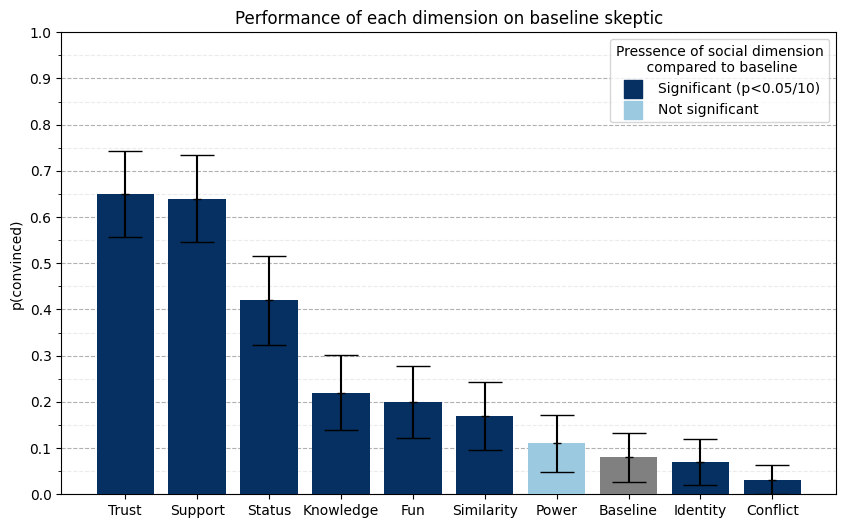

In [25]:
def plot_results(dimension_list, results, significances, counts, skeptic,savefig=False):
    plt.figure(figsize=(10,6))
    dim_labels = [dim.title() for dim in ['baseline']+dimension_list]
    sort_mask = np.argsort(results)[::-1] # reverse list to get descending order
    results = np.array(results)[sort_mask]
    dim_labels = np.array(dim_labels)[sort_mask]
    remove_romance_mask = dim_labels != "Romance"
    dim_labels = dim_labels[remove_romance_mask]
    results = results[remove_romance_mask]
    plt.grid(axis="y", ls="--")
    plt.gca().yaxis.set_minor_locator(MultipleLocator(0.05))
    plt.grid(which="minor", axis="y", ls="--", alpha=0.25)
    plt.bar(x = dim_labels, height = results, 
            color=["gray" if dim.lower() not in significances else plt.get_cmap("RdBu")(255) if significances[dim.lower()] else plt.get_cmap("RdBu")(175) for dim in dim_labels],
            zorder=101)

    xs, ys, yerr = get_info_for_errorbars(results,counts,dim_labels)
    
    plt.errorbar(
        x = xs, 
        y = ys,
        yerr= yerr, 
        c="k", 
        fmt="_", 
        capsize=12, 
        zorder=102)
    plt.ylim(0,1)
    plt.yticks([i/10 for i in range(11)])
    plt.ylabel("p(convinced)")
    plt.scatter([], [], marker="s", color=plt.get_cmap("RdBu")(255), s=150, label=f"Significant (p<{alpha}/{len(dimension_list)})")
    plt.scatter([], [], marker="s", color=plt.get_cmap("RdBu")(175), s=150, label="Not significant")
    plt.legend(title='Pressence of social dimension\n       compared to baseline')
    plt.title(f"Performance of each dimension on {skeptic} skeptic");
    if savefig:
        plt.savefig("../misc/images_for_report/baseline_skeptic_results.svg")

plot_results(dimension_list, results, significances, counts, "baseline",savefig=True)

## Easy skeptic

In [26]:
results_easy, counts_easy = zip(*[get_convinced_fraction(social_dim, save_folder = "_easy", return_counts=True) for social_dim in ["baseline"] + dimension_list])

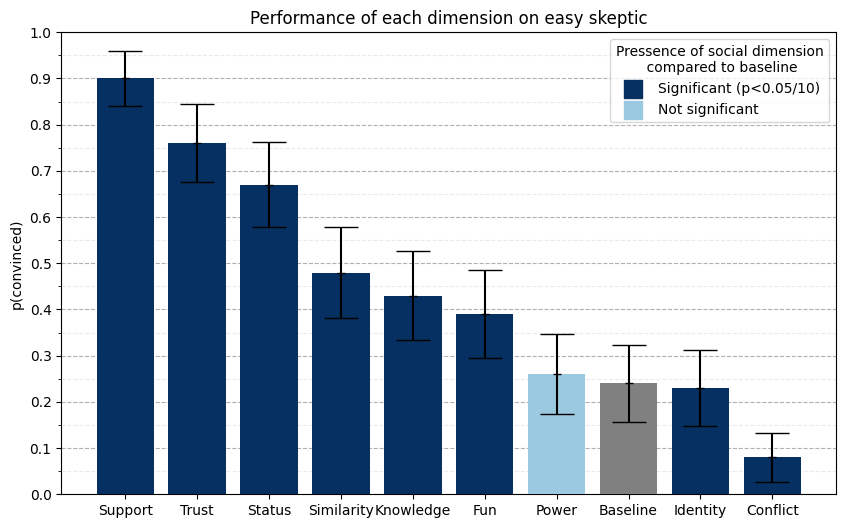

In [27]:
#dims_easy_ready = ["support", "knowledge", "power", "similarity", "status", "trust"] # remove later when all results are ready
plot_results(dimension_list, results_easy, significances, counts_easy, "easy")

## Hard skeptic

In [28]:
results_hard, counts_hard = zip(*[get_convinced_fraction(social_dim, save_folder = "_hard", return_counts=True) for social_dim in ["baseline"] + dimension_list])

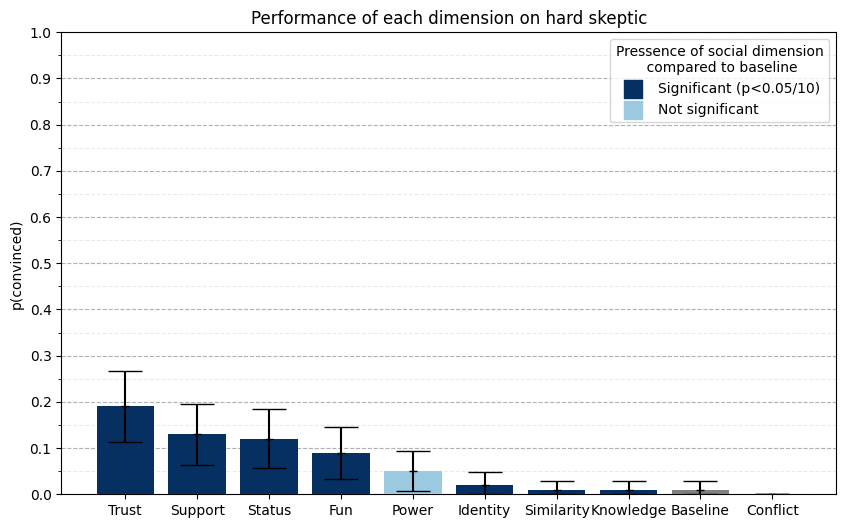

In [29]:
plot_results(dimension_list, results_hard, significances, counts_hard, "hard")

## Everything together

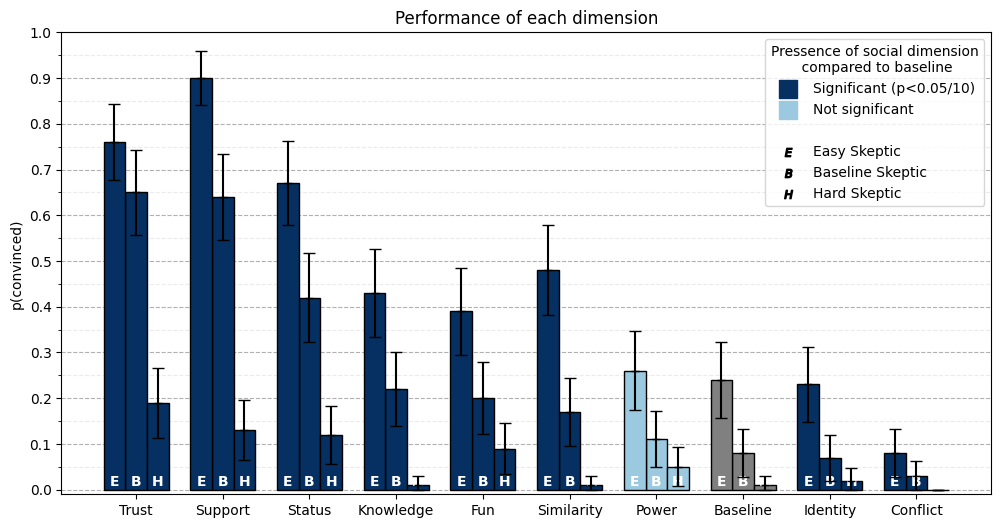

In [36]:
def plot_results_together(dimension_list, results, results_easy, results_hard, significances, counts, counts_easy, counts_hard):
    fig, ax = plt.subplots(1,1,figsize=(12,6))
    # extract social dims and results that are done for all skeptics
    dim_labels = [dim.title() for dim in ['baseline']+dimension_list]
    sort_mask = np.argsort(results)[::-1] # reverse list to get descending order
    results = np.array(results)[sort_mask]
    results_easy = np.array(results_easy)[sort_mask]
    results_hard = np.array(results_hard)[sort_mask]
    dim_labels = np.array(dim_labels)[sort_mask]
    remove_romance_mask = dim_labels != "Romance"
    dim_labels = dim_labels[remove_romance_mask]
    results = results[remove_romance_mask]
    results_easy = results_easy[remove_romance_mask]
    results_hard = results_hard[remove_romance_mask]


    # plot beautification
    plt.grid(axis="y", ls="--")
    plt.gca().yaxis.set_minor_locator(MultipleLocator(0.05))
    plt.grid(which="minor", axis="y", ls="--", alpha=0.25)
    colors=["gray" if dim.lower() not in significances else plt.get_cmap("RdBu")(255) if significances[dim.lower()] else plt.get_cmap("RdBu")(175) for dim in dim_labels]
    
    # define bars
    pos = np.array(range(len(dim_labels)))
    offset = 0.25
    width = 0.25
    bar_baseline = ax.bar(x = pos, height = results, width = width, edgecolor = "k", color=colors, zorder=100)
    bar_easy = ax.bar(x = pos - offset, height = results_easy, width = width, edgecolor = "k", color=colors, zorder=100)
    bar_hard = ax.bar(x = pos + offset, height = results_hard, width = width, edgecolor = "k", color=colors, zorder=100)
    
    xs, ys, yerr = get_info_for_errorbars(results,counts,pos)
    xs_easy,ys_easy,yerr_easy = get_info_for_errorbars(results_easy,counts_easy,pos)
    xs_hard,ys_hard,yerr_hard = get_info_for_errorbars(results_hard,counts_hard,pos)
    xs_easy,xs_hard = np.array(xs_easy),np.array(xs_hard)
    
    ax.errorbar(x = xs, y = ys, yerr=yerr, c="k", fmt="_", capsize=4, zorder=102)
    ax.errorbar(x = xs_easy - offset, y = ys_easy, yerr=yerr_easy, c="k", fmt="_", capsize=4, zorder=102)
    ax.errorbar(x = xs_hard + offset, y = ys_hard, yerr=yerr_hard, c="k", fmt="_", capsize=4, zorder=102)
    ax.set_ylim(-0.01,1)
    ax.set_xticks(pos)
    ax.set_xticklabels(dim_labels)
    ax.set_yticks([i/10 for i in range(11)])
    ax.set_ylabel("p(convinced)")
    ax.scatter([], [], marker="s", color=plt.get_cmap("RdBu")(255), s=150, label=f"Significant (p<{alpha}/{len(dimension_list)})")
    ax.scatter([], [], marker="s", color=plt.get_cmap("RdBu")(175), s=150, label="Not significant")
    ax.set_title(f"Performance of each dimension")
    
    bars = [bar_easy, bar_baseline, bar_hard]
    difficulties = ["E", "B", "H"]
    for idx, bar in enumerate(bars):
        letter = difficulties[idx]
        for i, rectangle in enumerate(bar):
            height = rectangle.get_height()
            plt.text(rectangle.get_x() + rectangle.get_width()/2, 0.001, letter, ha='center', va='bottom', weight = "bold", c = "white", zorder = 101)
    ;
    
    ax.scatter([], [], marker=' ', label=" ")
    for skeptic in ["Easy", "Baseline", "Hard"]:
        ax.scatter([], [], marker=f"${skeptic[0]}$", label=skeptic+" Skeptic", c="k")

    ax.legend(title='Pressence of social dimension\n       compared to baseline')
    plt.savefig("../misc/images_for_report/all_skeptics_results.svg")

plot_results_together(dimension_list, results, results_easy, results_hard, significances, counts, counts_easy, counts_hard)